<a href="https://colab.research.google.com/github/aikios/SAToxPredictions/blob/main/SDFtoCSV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialization


In [ ]:
##necessary imports
!pip install kora -q 
import os
import kora.install.rdkit
import gdown
import csv 
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Recap
from rdkit.Chem import PandasTools as pdt
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import FunctionalGroups
from collections import Counter

data_path = 'https://drive.google.com/uc?id=1KHv0zCSm9IokR47DvRaQzkaot0RJ2NOz'
catmos_qr50k = './CATMoS_QR50k.sdf'
gdown.download(data_path, catmos_qr50k, True)

     |████████████████████████████████| 61kB 2.5MB/s 
     |████████████████████████████████| 61kB 4.4MB/s 


'./CATMoS_QR50k.sdf'

In [ ]:
#@title IFG setup (run this block)

#  Original authors: Richard Hall and Guillaume Godin
#  This file is part of the RDKit.
#  The contents are covered by the terms of the BSD license
#  which is included in the file license.txt, found at the root
#  of the RDKit source tree.

#
#
# Richard hall 2017
# IFG main code
# Guillaume Godin 2017
# refine output function
# astex_ifg: identify functional groups a la Ertl, J. Cheminform (2017) 9:36
from collections import namedtuple

def merge(mol, marked, aset):
    bset = set()
    for idx in aset:
        atom = mol.GetAtomWithIdx(idx)
        for nbr in atom.GetNeighbors():
            jdx = nbr.GetIdx()
            if jdx in marked:
                marked.remove(jdx)
                bset.add(jdx)
    if not bset:
        return
    merge(mol, marked, bset)
    aset.update(bset)

# atoms connected by non-aromatic double or triple bond to any heteroatom
# c=O should not match (see fig1, box 15).  I think using A instead of * should sort that out?
PATT_DOUBLE_TRIPLE = Chem.MolFromSmarts('A=,#[!#6]')
# atoms in non aromatic carbon-carbon double or triple bonds
PATT_CC_DOUBLE_TRIPLE = Chem.MolFromSmarts('C=,#C')
# acetal carbons, i.e. sp3 carbons connected to tow or more oxygens, nitrogens or sulfurs; these O, N or S atoms must have only single bonds
PATT_ACETAL = Chem.MolFromSmarts('[CX4](-[O,N,S])-[O,N,S]')
# all atoms in oxirane, aziridine and thiirane rings
PATT_OXIRANE_ETC = Chem.MolFromSmarts('[O,N,S]1CC1')

PATT_TUPLE = (PATT_DOUBLE_TRIPLE, PATT_CC_DOUBLE_TRIPLE, PATT_ACETAL, PATT_OXIRANE_ETC)

def identify_functional_groups(mol):
    marked = set()
#mark all heteroatoms in a molecule, including halogens
    for atom in mol.GetAtoms():
        if atom.GetAtomicNum() not in (6,1): # would we ever have hydrogen?
            marked.add(atom.GetIdx())

#mark the four specific types of carbon atom
    for patt in PATT_TUPLE:
        for path in mol.GetSubstructMatches(patt):
            for atomindex in path:
                marked.add(atomindex)

#merge all connected marked atoms to a single FG
    groups = []
    while marked:
        grp = set([marked.pop()])
        merge(mol, marked, grp)
        groups.append(grp)

#extract also connected unmarked carbon atoms
    ifg = namedtuple('IFG', ['atomIds', 'atoms', 'type'])
    ifgs = []
    for g in groups:
        uca = set()
        for atomidx in g:
            for n in mol.GetAtomWithIdx(atomidx).GetNeighbors():
                if n.GetAtomicNum() == 6:
                    uca.add(n.GetIdx())
        ifgs.append(ifg(atomIds=tuple(list(g)), atoms=Chem.MolFragmentToSmiles(mol, g, canonical=True), type=Chem.MolFragmentToSmiles(mol, g.union(uca),canonical=True)))
    return ifgs

def main():
    for ix, smiles in enumerate([
        'Cc1nc(NS(=O)(=O)c2ccc(N)cc2)nc(C)c1', # fig1, 1
        'NC(=N)c1ccc(C=Cc2ccc(cc2O)C(=N)N)cc1', # 2
        'CC(=O)Nc1nnc(s1)S(=O)(=O)N', # 3
        'NS(=O)(=O)c1cc2c(NCNS2(=O)=O)cc1Cl', # 4
        'CNC1=Nc2ccc(Cl)cc2C(=N(=O)C1)c3ccccc3', # 5
        'Cc1onc(c1C(=O)NC2C3SC(C)(C)C(N3C2=O)C(=O)O)c4ccccc4', # 6
        'Clc1ccccc1C2=NCC(=O)Nc3ccc(cc23)N(=O)=O', # 7
        'COc1cc(cc(C(=O)NCC2CCCN2CC=C)c1OC)S(=O)(=O)N', # 8
        'Cc1ccc(Cl)c(Nc2ccccc2C(=O)O)c1Cl', # 9
        'Clc1ccc2Oc3ccccc3N=C(N4CCNCC4)c2c1', # 10 - there is a discrepancy with the paper here!  I wonder if Peter has the ring as aromatic?
        'FC(F)(F)CN1C(=O)CN=C(c2ccccc2)c3cc(Cl)ccc13', # 11
        'OCC1OC(CC1O)n2cnc3C(O)CNC=Nc32', # 12
        'CCNC1CC(C)S(=O)(=O)c2sc(cc12)S(=O)(=O)N', # 13
        'CC(O)C1C2C(C)C(=C(N2C1=O)C(=O)O)SC3CNC(C3)C(=O)N(C)C', # 14
        'CC1CN(CC(C)N1)c2c(F)c(N)c3c(=O)c(cn(C4CC4)c3c2F)C(=O)O', # 15
        'CC(=CCC1C(=O)N(N(C1=O)c2ccccc2)c3ccccc3)C', # 16
        'Clc1ccc2N=C3NC(=O)CN3Cc2c1Cl', # 17
        'CC(=O)NC1C(NC(=N)N)C=C(OC1C(O)C(O)CO)C(=O)O', # 18
        'CC(O)C(O)C1CNc2nc(N)nc(O)c2N1', # 19
        'NC1CCCCN(C1)c2c(Cl)cc3c(=O)c(cn(C4CC4)c3c2Cl)C(=O)O', # 20
    ]):
        m = Chem.MolFromSmiles(smiles)
        fgs = identify_functional_groups(m)
        print('%2d: %d fgs'%(ix+1, len(fgs)), fgs)


if __name__ == "__main__":
    main()


Cc1c(I)c(=O)n(-c2ccccc2)n1C


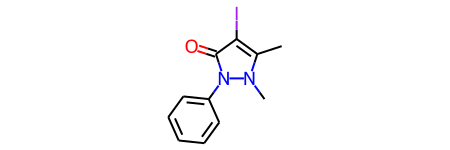

In [ ]:
##examples of IFG and RDKit usage
suppl = Chem.SDMolSupplier('CATMoS_QR50k.sdf')
t = Chem.MolToSmiles(suppl[60])
print(t)
suppl[60]

In [ ]:
##example of functional group identification
identify_functional_groups(suppl[60])

# SDF TO CSV

In [ ]:
##dataframe creation
frame = pdt.LoadSDF(catmos_qr50k,smilesName='SMILES',molColName='Molecule', includeFingerprints=True)
frame.info

In [ ]:
##adding functional groups column
frame["functionalgroups"] = ""

In [ ]:
##for loop to identify, clean, and append functional groups
iter = 0
for mol in suppl:
  try:
    k = identify_functional_groups(mol)
    z = []
    for e in k:
      b = str(e)[4:-1]
      y = b.index('type')
      x = y + 6
      d = str(b)[x:-1]
      z.append(d)
    print(z)
    frame.at[iter,'functionalgroups'] = z
  except:
    print("an exception...")
  iter += 1
  
  
  

  ## use iterator for dataframe insertion

In [ ]:
##creating csv for later use
frame.to_csv('catmos_withfgs.csv')

RDKit WARNING: [02:44:31] unsupported number of radical electrons 4
